In [1]:
from __future__ import absolute_import, division, print_function, \
    unicode_literals

import argparse
from collections import OrderedDict
from glob import glob
from IPython.display import Image, display, clear_output
import os
from os import listdir
import PIL

import numpy as np
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.models as models
import yaml

from dataset_utils import text_processing
from train_model.Engineer import one_stage_run_model, masked_unk_softmax
from train_model.model_factory import prepare_model



# Get test images
# wget http://images.cocodataset.org/zips/test2015.zip, unzip and update path to image directory
im_dir = '/private/home/nvivek/vqa_2.0/test2015'

# Get the models
# wget https://s3-us-west-1.amazonaws.com/pythia-vqa/pretrained_models/detectron_100_resnet_most_data.tar.gz
# move the best_model.pth and config.yaml from the uncompressed file to the folder vqa_detectron_master

# mkdir vqa_detectron_master

config_file = '/private/home/nvivek/VQA/pythia/vqa_detectron_master/config.yaml'
model_file = '/private/home/nvivek/VQA/pythia/vqa_detectron_master/best_model.pth'


# Get data
# mkdir data
# cd data
# wget https://s3-us-west-1.amazonaws.com/pythia-vqa/data/vqa2.0_glove.6B.300d.txt.npy
# wget https://s3-us-west-1.amazonaws.com/pythia-vqa/data/vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/pythia-vqa/data/answers_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/pythia-vqa/data/large_vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/pythia-vqa/data/large_vqa2.0_glove.6B.300d.txt.npy

# Ensure the files fc7_b.pkl and fc7_w.pkl are also present

TARGET_IMAGE_SIZE = [448, 448]
CHANNEL_MEAN = [0.485, 0.456, 0.406]
CHANNEL_STD = [0.229, 0.224, 0.225]
data_transforms = transforms.Compose([transforms.Resize(TARGET_IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(CHANNEL_MEAN,
                                                           CHANNEL_STD)])

use_cuda = torch.cuda.is_available()

# NOTE feat path "https://download.pytorch.org/models/resnet152-b121ed2d.pth"
RESNET152_MODEL = models.resnet152(pretrained=True)
RESNET152_MODEL.eval()

if use_cuda:
    RESNET152_MODEL = RESNET152_MODEL.cuda()

class ResNet152FeatModule(nn.Module):
    def __init__(self):
        super(ResNet152FeatModule, self).__init__()
        modules = list(RESNET152_MODEL.children())[:-2]
        self.feature_module = nn.Sequential(*modules)

    def forward(self, x):
        return self.feature_module(x)

resnet_module = ResNet152FeatModule()
if use_cuda:
    resnet_module = resnet_module.cuda()
    
def get_image():
    im_files = [f for f in os.listdir(im_dir)]
    im_file = random.choice(im_files)
    im_path = os.path.join(im_dir, im_file)
    print(im_path)
    clear_output()
    display(Image(filename=im_path))
    return im_file

def extract_resnet_feat(im_file):
    if not os.path.isabs(im_file):
        im_file = os.path.join(im_dir, im_file)
    img = PIL.Image.open(im_file).convert('RGB')
    img_transform = data_transforms(img)
    # make sure grey scale image is processed correctly
    if img_transform.shape[0] == 1:
        img_transform = img_transform.expand(3, -1, -1)
    img_var = Variable(img_transform.unsqueeze(0))
    if use_cuda:
        img_var = img_var.cuda()

    img_feat = resnet_module(img_var)
    img_feat = img_feat.permute(0, 2, 3, 1).view(196,-1)
    return img_feat

def print_result(soft_max_result, ans_dict):
    predicted_answers = np.argmax(soft_max_result, axis=1)
    for idx, pred_idx in enumerate(predicted_answers):
        pred_ans = ans_dict.idx2word(pred_idx)
        print(pred_ans)

def prepare_sample(vocab_dict, im_file, question_tokens, question_max_len=14):
    input_seq = np.zeros((question_max_len), np.int32)
    question_inds = (
        [vocab_dict.word2idx(w) for w in question_tokens])
    seq_length = len(question_inds)
    read_len = min(seq_length, question_max_len)
    input_seq[:read_len] = question_inds[:read_len]
    sample = dict(input_seq_batch=torch.from_numpy(input_seq).unsqueeze(0),
                  seq_length_batch=torch.tensor((seq_length,)).unsqueeze(0))

    image_feats = []
    # append detectron feature
    image_feats.append(torch.rand(100,2048))
    # append resnet feature
    image_feats.append(extract_resnet_feat(im_file))

    for im_idx, image_feat in enumerate(image_feats):
        if im_idx == 0:
            sample['image_feat_batch'] = image_feat.unsqueeze(0)
        else:
            feat_key = "image_feat_batch_%s" % str(im_idx)
            sample[feat_key] = image_feat.unsqueeze(0)


    # harcoded for now - set to 100
    sample['image_dim'] = torch.tensor((100,))
    return sample
    
def evaluate_sample(model, data_set, im_file, question, UNK_idx=0):
    question_tokens = text_processing.tokenize(question)
    sample = prepare_sample(data_set, im_file, question_tokens)
    logit_res = one_stage_run_model(sample, model, eval_mode=True)
    softmax_res = masked_unk_softmax(logit_res, dim=1, mask_idx=UNK_idx)
    softmax_res = softmax_res.data.cpu().numpy().astype(np.float16)
    return softmax_res

def demo():

    with open(config_file, 'r') as f:
        config = yaml.load(f)
    
    data_root_dir = config['data']['data_root_dir']
        
    vocab_dict = text_processing.VocabDict(os.path.join(data_root_dir, config['data']['vocab_question_file']))
    ans_dict = text_processing.VocabDict(os.path.join(data_root_dir, config['data']['vocab_answer_file']))

    num_image_feat = len(config['data']['image_feat_train'][0].split(','))
    num_vocab_txt = vocab_dict.num_vocab
    num_answers = ans_dict.num_vocab

    myModel = prepare_model(num_vocab_txt, num_answers, **config['model'],
                            num_image_feat=num_image_feat)
    state_dict = torch.load(model_file)['state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace('module.','')
        new_state_dict[name] = v
    
    myModel.load_state_dict(new_state_dict)

    
    print('VQA Demo')
    print('Say next to go to next image')
    print('Say stop to stop demo')
    im_file = get_image()
      
    while(True):
        print("What question would you like to ask?")
        question_str = input()
        if question_str.lower() == 'next':
            im_file = get_image()
            continue
        if question_str.lower() == 'stop':
            print('Bye')
            break
    
        soft_max_result = evaluate_sample(myModel, vocab_dict, im_file, question_str)
        print_result(soft_max_result, ans_dict)

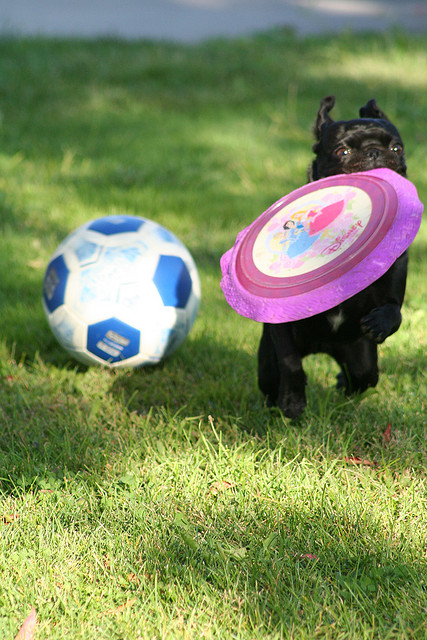

What question would you like to ask?
what is this?
dog
What question would you like to ask?


KeyboardInterrupt: 

In [2]:
demo()